In [132]:
%load_ext autoreload
%autoreload 2
from utils import plot_utils, Lapse_model
from utils import custom_functions as cuf
import os
import sys
from OpenEphys_Analysis.utils.custom_functions import update_progress
import glob
import ntpath
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import math
import seaborn as sns
import pandas as pd
import warnings
#from itertools import chains
from scipy import stats
import scipy.optimize as opt
import random
from IPython.display import clear_output
from datetime import date
import pingouin as pg
from sklearn.linear_model import LinearRegression
import dill
from itertools import chain
clear_output()

In [133]:
# Chronic lesion
DS_name = 'ChronicLesions_Dec21'
DS_name = 'Chronic_lesion_and_controls_Jul2021'

# path to the dataset
data_directory = cuf.get_data_folder() + '/Behavioural_Data/Bpod_data/' + DS_name + '_Analysis/'
# dataframe name
df_name = DS_name + '_dataframe.pkl'

# Read the dataframe
df_to_plot = pd.read_pickle(data_directory + df_name)

# Print output for report
print('Date of analysis:', date.today())
print('Output folder:', data_directory)

Date of analysis: 2022-02-16
Output folder: /mnt/c/Users/herny/Desktop/SWC/Data/Behavioural_Data/Bpod_data/Chronic_lesion_and_controls_Jul2021_Analysis/


In [134]:
# add more data

In [135]:
# Select only the auditory for now
protocols_selected = ['Auditory']
df_to_plot = df_to_plot[df_to_plot.Protocol.isin(protocols_selected)]
print('Protocols selected:', protocols_selected)

Protocols selected: ['Auditory']


In [136]:
# select trials up to a certain number
trials_up_to = 5000
df_to_plot = df_to_plot[df_to_plot['CumulativeTrialNumberByProtocol'] < trials_up_to]
print('Selection of trials less than ', trials_up_to)

Selection of trials less than  5000


In [137]:
# Remove change of contingency if any
cont_to_remove = 2
df_to_plot = df_to_plot[df_to_plot['Contingency'] != cont_to_remove]

In [138]:
# removal of the first trials of each session
tr_beginning = 5
df_to_plot = df_to_plot[df_to_plot['TrialIndex'] > tr_beginning]
print('Removal of the first', tr_beginning, 'trials of each session')

Removal of the first 5 trials of each session


In [139]:
# substitute nans by 0s in firstpokecorrect as otherwise are not counted for the performance
df_to_plot['FirstPokeCorrect'] = df_to_plot['FirstPokeCorrect'].fillna(value=0)

In [140]:
df_to_plot.ExperimentalGroup.unique()

array(['Lesion', 'Cortex_Buffer'], dtype=object)

In [141]:
# Select only controls
df_to_plot = df_to_plot[df_to_plot['ExperimentalGroup'].isin(['Control', 'Cortex_Buffer'])]

In [142]:
# maximum number of trials performed per mouse in the dataset:
df_to_plot.groupby(['AnimalID', 'ExperimentalGroup', 'Protocol']).max()['CumulativeTrialNumberByProtocol']

AnimalID  ExperimentalGroup  Protocol
CL-01     Cortex_Buffer      Auditory    4999.0
CL-02     Cortex_Buffer      Auditory    4999.0
CL-03     Cortex_Buffer      Auditory    4999.0
CL-05     Cortex_Buffer      Auditory    4999.0
CL-06     Cortex_Buffer      Auditory    4999.0
CL-08     Cortex_Buffer      Auditory    4999.0
CL-09     Cortex_Buffer      Auditory    4999.0
CL-10     Cortex_Buffer      Auditory    4999.0
CL-11     Cortex_Buffer      Auditory    4999.0
Name: CumulativeTrialNumberByProtocol, dtype: float64

In [143]:
# calculate the bias of repeating the same action if previous trial was correct or not
df_to_plot.columns

Index(['AnimalID', 'ExperimentalGroup', 'SessionTime', 'FullSessionTime',
       'Protocol', 'Stimulation', 'Muscimol', 'RewardChange',
       'RewardChangeBlock', 'CenterPortDuration', 'Contingency',
       'RewardAmount', 'PunishDelay', 'Punish', 'BiasCorrection', 'TrialIndex',
       'TrialHighPerc', 'Outcomes', 'OptoStim', 'FirstPokeCorrect',
       'FirstPoke', 'TrialSide', 'TrialSequence', 'ResponseTime',
       'TrialStartTimestamp', 'CumulativePerformance', 'SwitchSide',
       'PreviousChoice', 'TrialEvents', 'TrialStates', 'FullGUI', 'SessionID',
       'ITIs', 'CumulativeTrialNumber', 'CumulativeTrialNumberByProtocol',
       'CurrentPastPerformance20', 'CurrentPastPerformance100',
       'NoOfCenterPokes', 'MiddleWaitTime', 'TrialInitiationTime', 'RightBias',
       'TrialsSpeed', 'PrevTrialSuccess'],
      dtype='object')

In [160]:
def analyze_switch_trials(df):
    # get info for the sessions
    sessionsID = pd.unique(df['SessionID'])
    # initialize list to hold dataframes
    sessionsInfo = []   

    # fill the new dataframe with info for each session
    for session in sessionsID:
        # get the dataframe for that session
        Sdf = df[df['SessionID'] == session]
        # split the dataset into previous correct and wrong
        Cdf = Sdf[Sdf['PrevTrialSuccess'] == 1]
        Wdf = Sdf[Sdf['PrevTrialSuccess'] == 0]
        # percentage of correct trials on stay trials
        stay_pc = 100 * np.sum(Cdf[Cdf['SwitchSide'] == 0]['FirstPokeCorrect'] == 1)/len(Cdf[Cdf['SwitchSide'] == 0])
        # percentage of correct trials on switch trials
        switch_pc = 100 * np.sum(Cdf[Cdf['SwitchSide'] == 1]['FirstPokeCorrect'] == 1)/len(Cdf[Cdf['SwitchSide'] == 1])
        # percentage of incorrect trials on stay trials
        stay_pi = 100 * np.sum(Wdf[Wdf['SwitchSide'] == 0]['FirstPokeCorrect'] == 1)/len(Wdf[Wdf['SwitchSide'] == 0])
        # percentage of incorrect trials on switch trials
        switch_pi = 100 * np.sum(Wdf[Wdf['SwitchSide'] == 1]['FirstPokeCorrect'] == 1)/len(Wdf[Wdf['SwitchSide'] == 1])
        #session performance
        session_performance = 100 * np.sum(Sdf.FirstPokeCorrect) / Sdf.shape[0]
        
        # get the animal name
        animal_name = session.split(' ')[0]
  
        # append it to list
        sessionsInfo.append([session, session_performance, stay_pc, switch_pc, stay_pi, switch_pi, animal_name])

        
    # fill the dataframe
    SessionDF = pd.DataFrame({'animal_id': [x[6] for x in sessionsInfo], 
                              'session_time': [x[0] for x in sessionsInfo],
                              'total_performance': [x[1] for x in sessionsInfo],
                              'stay_pc': [x[2] for x in sessionsInfo],
                              'switch_pc': [x[3] for x in sessionsInfo],
                              'stay_pi': [x[4] for x in sessionsInfo],
                              'switch_pi': [x[5] for x in sessionsInfo],
                             })
        

    # merge into a single df and return
    return SessionDF

In [161]:
dfForBP = analyze_switch_trials(df_to_plot)

In [162]:
# calculate the differences
dfForBP['strategy_bias_correct'] = dfForBP.stay_pc - dfForBP.switch_pc
dfForBP['strategy_bias_incorrect'] = dfForBP.stay_pi - dfForBP.switch_pi

In [163]:
# bin the performance of the session
dfForBP["perf_binned_10"] = (dfForBP.total_performance // 10) * 10 + 5

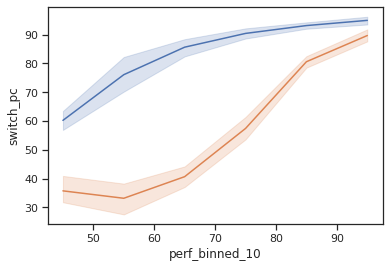

In [164]:
sns.lineplot(data=dfForBP, x='perf_binned_10', y='stay_pc')#, hue='animal_id')
sns.lineplot(data=dfForBP, x='perf_binned_10', y='switch_pc')

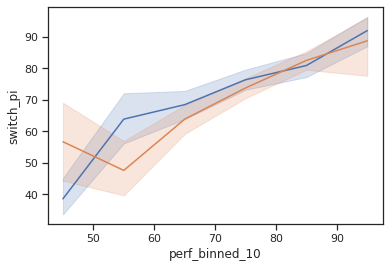

In [165]:
sns.lineplot(data=dfForBP, x='perf_binned_10', y='stay_pi')#, hue='animal_id')
sns.lineplot(data=dfForBP, x='perf_binned_10', y='switch_pi')

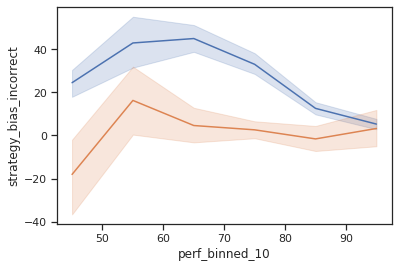

In [167]:
sns.lineplot(data=dfForBP, x='perf_binned_10', y='strategy_bias_correct')#, hue='animal_id')
sns.lineplot(data=dfForBP, x='perf_binned_10', y='strategy_bias_incorrect')#, hue='animal_id')